In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from os.path import join
from os import getcwd
from IPython.display import clear_output

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.preprocessing import PolynomialFeatures

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.metrics import AUC # Area under the curve, default: ROC
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, TensorBoard
from keras.optimizers.schedules import ExponentialDecay
from keras.initializers import GlorotNormal
from keras.regularizers import l1, l2

In [4]:
from functions import *

In [5]:
checkpoints_path = getcwd()+'\\checkpoints_B'
tensor_path = getcwd()+'\\tensor_B'

In [6]:
df = pd.read_csv('../../databases/diabetes.csv')
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Tomando el EDA del Tp1, se reemplazan los valores no medidos por NaN y se quitan los outlayers para luego reemplazarlos por la media o la mediana

In [7]:
outlayers = {
    'BloodPressure': (40, np.Inf),
    'SkinThickness': (0, 80),
    'Insulin': (0, 400),
    'BMI': (0, 50)
}

zeros = [
    'Glucose',
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'BMI'
]
x_df = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']]
y_df = df['Outcome']

In [8]:
# Split dataset into 15% test, 85% train 
x_temp, x_test, y_temp, y_test = train_test_split(x_df, y_df, test_size=0.15, random_state=0)
x_train, x_valid, y_train, y_valid = train_test_split(x_temp, y_temp, test_size=0.15, random_state=0)

In [9]:
# Reemplazo los valores nulos y los outlayer
x_train_clean, _data = replace_outliers_zeros(x_train, outlayers, zeros, mean_median=True)
x_test_clean, _data = replace_outliers_zeros(x_test, outlayers, zeros, mean_median=True, data_to_replace=_data)
x_valid_clean, _data = replace_outliers_zeros(x_valid, outlayers, zeros, mean_median=True, data_to_replace=_data)
# Normalizo los datasets
x_train_norm, _norm_dict = normalize(x_train_clean, None)
x_valid_norm, _norm_dict = normalize(x_valid_clean, _norm_dict)
x_test_norm, _norm_dict = normalize(x_test_clean, _norm_dict)

In [10]:
temp = {}
for key in _norm_dict:
    temp[key] = [0,1]

x_train_clean_2, _norm_ = normalize(x_train_clean, temp)
x_valid_clean_2, _norm_ = normalize(x_valid_clean, temp)
x_test_clean_2, _norm_ = normalize(x_test_clean, temp)

In [11]:
x_valid_clean_2.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,3.897959,122.836735,70.998125,29.582509,150.644712,31.501331,0.456194,33.091837
std,3.390374,29.751442,9.852806,8.664269,55.743782,5.947515,0.387583,11.432533
min,0.000000,67.000000,44.000000,11.000000,14.000000,18.200000,0.118000,21.000000
25%,1.000000,100.000000,64.000000,25.500000,149.000000,27.950000,0.194750,25.000000
50%,3.000000,120.000000,72.000000,29.002525,155.118881,31.600000,0.333000,30.000000
75%,6.000000,141.750000,76.000000,31.750000,155.118881,34.575000,0.560750,38.750000
max,13.000000,195.000000,96.000000,63.000000,392.000000,47.900000,2.420000,72.000000


## Features Polinomiales

Primero utilizadano el mejor modelo obtenido anteriormente vamos a probar aumentando el orden para entrenar varios modelos y asi obtener el mejor para luego trabajar sobre dicho modelo

In [12]:
stop_early = EarlyStopping(monitor='val_auc', patience=50)
learning_schedule = ExponentialDecay(initial_learning_rate=4.7, decay_steps=100, decay_rate=0.96)

In [13]:
max_poly_order = 10

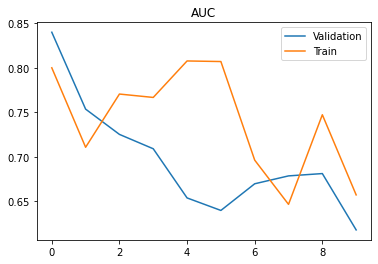

Wall time: 3min 59s


In [14]:
%%time
train_score = [0.8]
validation_score = [0.84]
all_metrics = {}

for i in range(2,max_poly_order+1):
    
    name = 'poly_{}'.format(i)
    checkdir = join(checkpoints_path, name)
    tensordir = join(tensor_path, name)
    tensor_call = TensorBoard(log_dir=tensordir)

    poly = PolynomialFeatures(degree=i)
    pol_x_train = poly.fit_transform(x_train_norm)
    pol_x_valid = poly.fit_transform(x_valid_norm)
    
    poly_checkpoint_callback = ModelCheckpoint(filepath=join(checkdir),
                                                  save_weights_only=True,
                                                  monitor='val_auc',
                                                  mode='max',
                                                  save_best_only=True)
    
    poly_model = Sequential()
    poly_model.add(Dense(units=1, activation='sigmoid', input_shape=(pol_x_train.shape[1],)))
    poly_model.compile(optimizer=SGD(learning_rate=4.7, momentum=0.999), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])

    history = poly_model.fit(pol_x_train, y_train, epochs=100, validation_data=(pol_x_valid, y_valid), callbacks=[poly_checkpoint_callback, tensor_call], 
                             verbose=1)
    
    # Cargo el mejor modelo entrenado
    poly_model.load_weights(checkdir)
    metrics = verify_model(poly_model, pol_x_train, y_train, pol_x_valid, y_valid)
    # Guardo las metricas de cada orden para comparar
    all_metrics[i] = metrics
    train_score.append(metrics['AUC ROC'][0])
    validation_score.append(metrics['AUC ROC'][1])
    clear_output(wait=True)
    
plt.plot(validation_score, label='Validation')
plt.plot(train_score, label='Train')
plt.title('AUC')
plt.legend(loc='best')
plt.show()

No se consiguieron los resultados esperados, primero se puede observar que el modelo no generaliza de la mejor manera, con lo cual se puede evidenciar un cierto grado de overfitting, pero ademas en cada iteración se observaba que no se minimizaba la loss por lo tanto se debe corregir el optimizador o sus hyperparámetros

Probamos con un learning rate mas grande

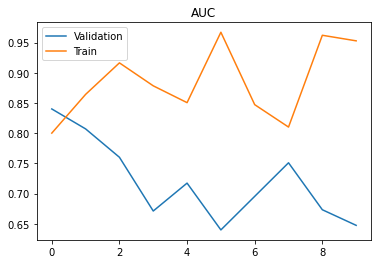

Wall time: 3min 59s


In [15]:
%%time

train_score = [0.8]
validation_score = [0.84]
all_metrics = {}

for i in range(2,max_poly_order+1):
    name = 'poly_adam_{}'.format(i)
    checkdir = join(checkpoints_path, name)
    tensordir = join(tensor_path, name)
    tensor_call = TensorBoard(log_dir=tensordir)
    
    learning_schedule = ExponentialDecay(initial_learning_rate=4.7*(10**(i-1)), decay_steps=100, decay_rate=0.96)
    poly = PolynomialFeatures(degree=i)
    pol_x_train = poly.fit_transform(x_train_norm)
    pol_x_valid = poly.fit_transform(x_valid_norm)
    
    poly_checkpoint_callback = ModelCheckpoint(filepath=checkdir,
                                                  save_weights_only=True,
                                                  monitor='val_auc',
                                                  mode='max',
                                                  save_best_only=True)
    
    poly_model = Sequential()
    poly_model.add(Dense(units=1, activation='sigmoid', input_shape=(pol_x_train.shape[1],)))
    poly_model.compile(optimizer=Adam(learning_rate=0.2), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])

    history = poly_model.fit(pol_x_train, y_train, epochs=100, validation_data=(pol_x_valid, y_valid), callbacks=[poly_checkpoint_callback, tensor_call], 
                             verbose=1)
    
    # Cargo el mejor modelo entrenado
    poly_model.load_weights(checkdir)
    metrics = verify_model(poly_model, pol_x_train, y_train, pol_x_valid, y_valid)
    # Guardo las metricas de cada orden para comparar
    all_metrics[i] = metrics
    train_score.append(metrics['AUC ROC'][0])
    validation_score.append(metrics['AUC ROC'][1])
    clear_output(wait=True)
    
plt.plot(validation_score, label='Validation')
plt.plot(train_score, label='Train')
plt.title('AUC')
plt.legend(loc='best')
plt.show()

Utilizadno el optimizador Adam se obtuvieron resultados que se pueden consideerar mejores, pero ahora se puede observar un claro overfiting con lo que se trabajaran los diversos regularizadores para buscar minimizarlo

### Dropout

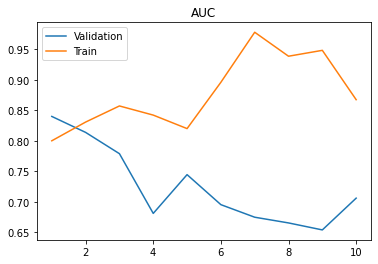

Wall time: 4min 39s


In [16]:
%%time

train_score = [0.8]
validation_score = [0.84]
all_metrics = {}

for i in range(2,max_poly_order+1):
    name = 'poly_drop_{}'.format(i)
    checkdir = join(checkpoints_path, name)
    tensordir = join(tensor_path, name)
    tensor_call = TensorBoard(log_dir=tensordir)
    
    learning_schedule = ExponentialDecay(initial_learning_rate=4.7*(10**(i-1)), decay_steps=100, decay_rate=0.96)
    poly = PolynomialFeatures(degree=i)
    pol_x_train = poly.fit_transform(x_train_norm)
    pol_x_valid = poly.fit_transform(x_valid_norm)
    
    poly_checkpoint_callback = ModelCheckpoint(filepath=checkdir,
                                                  save_weights_only=True,
                                                  monitor='val_auc',
                                                  mode='max',
                                                  save_best_only=True)
    
    poly_model = Sequential()
    poly_model.add(Dropout(rate=0.4, input_shape=(pol_x_train.shape[1],)))
    poly_model.add(Dense(units=1, activation='sigmoid', input_shape=(pol_x_train.shape[1],)))
    poly_model.compile(optimizer=Adam(learning_rate=0.2), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])

    history = poly_model.fit(pol_x_train, y_train, epochs=100, validation_data=(pol_x_valid, y_valid), callbacks=[poly_checkpoint_callback, tensor_call], 
                             verbose=1)
    
    # Cargo el mejor modelo entrenado
    poly_model.load_weights(checkdir)
    metrics = verify_model(poly_model, pol_x_train, y_train, pol_x_valid, y_valid)
    # Guardo las metricas de cada orden para comparar
    all_metrics[i] = metrics
    train_score.append(metrics['AUC ROC'][0])
    validation_score.append(metrics['AUC ROC'][1])
    clear_output(wait=True)
    
plt.plot(list(range(1, max_poly_order+1)),validation_score, label='Validation')
plt.plot(list(range(1, max_poly_order+1)),train_score, label='Train')
plt.title('AUC')
plt.legend(loc='best')
plt.show()

No se obtuvieron mejoras considerables

### Reguralizador L1

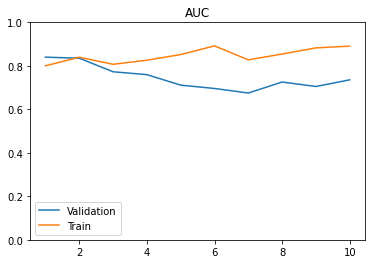

Wall time: 3min 34s


In [17]:
%%time

train_score = [0.8]
validation_score = [0.84]
all_metrics = {}

for i in range(2,max_poly_order+1):
    name = 'poly_l1_{}'.format(i)
    checkdir = join(checkpoints_path, name)
    tensordir = join(tensor_path, name)
    tensor_call = TensorBoard(log_dir=tensordir)
    
    learning_schedule = ExponentialDecay(initial_learning_rate=4.7*(10**(i-1)), decay_steps=100, decay_rate=0.96)
    poly = PolynomialFeatures(degree=i)
    pol_x_train = poly.fit_transform(x_train_norm)
    pol_x_valid = poly.fit_transform(x_valid_norm)
    
    l1_checkpoint_callback = ModelCheckpoint(filepath=checkdir,
                                                  save_weights_only=True,
                                                  monitor='val_auc',
                                                  mode='max',
                                                  save_best_only=True)
    
    poly_model = Sequential()
    poly_model.add(Dense(units=1, activation='sigmoid', input_shape=(pol_x_train.shape[1],), 
                         kernel_regularizer=l1(0.05), activity_regularizer=l1(0.5)))
    poly_model.compile(optimizer=Adam(learning_rate=0.2), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])

    history = poly_model.fit(pol_x_train, y_train, epochs=100, validation_data=(pol_x_valid, y_valid), callbacks=[l1_checkpoint_callback, tensor_call], 
                             verbose=1)
    
    # Cargo el mejor modelo entrenado
    poly_model.load_weights(checkdir)
    metrics = verify_model(poly_model, pol_x_train, y_train, pol_x_valid, y_valid)
    # Guardo las metricas de cada orden para comparar
    all_metrics[i] = metrics
    train_score.append(metrics['AUC ROC'][0])
    validation_score.append(metrics['AUC ROC'][1])
    clear_output(wait=True)
    
plt.plot(list(range(1, max_poly_order+1)),validation_score, label='Validation')
plt.plot(list(range(1, max_poly_order+1)),train_score, label='Train')
plt.ylim([0.0, 1.0])
plt.title('AUC')
plt.legend(loc='best')
plt.show()

### Regularización L2

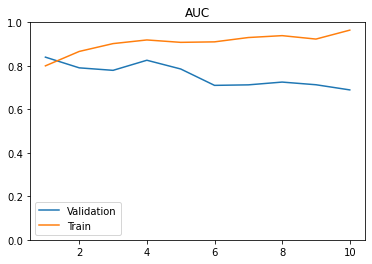

Wall time: 4min 44s


In [18]:
%%time

train_score = [0.8]
validation_score = [0.84]
all_metrics = {}

for i in range(2,max_poly_order+1):
    name = 'poly_l2_{}'.format(i)
    checkdir = join(checkpoints_path, name)
    tensordir = join(tensor_path, name)
    tensor_call = TensorBoard(log_dir=tensordir)
    
    learning_schedule = ExponentialDecay(initial_learning_rate=4.7*(10**(i-1)), decay_steps=100, decay_rate=0.96)
    poly = PolynomialFeatures(degree=i)
    pol_x_train = poly.fit_transform(x_train_norm)
    pol_x_valid = poly.fit_transform(x_valid_norm)
    
    l2_checkpoint_callback = ModelCheckpoint(filepath=checkdir,
                                                  save_weights_only=True,
                                                  monitor='val_auc',
                                                  mode='max',
                                                  save_best_only=True)
    
    poly_model = Sequential()
    poly_model.add(Dense(units=1, activation='sigmoid', input_shape=(pol_x_train.shape[1],),  
                        kernel_regularizer=l2(0.05)))
    poly_model.compile(optimizer=Adam(learning_rate=0.02), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])

    history = poly_model.fit(pol_x_train, y_train, epochs=200, validation_data=(pol_x_valid, y_valid), callbacks=[l2_checkpoint_callback, tensor_call], 
                             verbose=1)
    
    # Cargo el mejor modelo entrenado
    poly_model.load_weights(checkdir)
    metrics = verify_model(poly_model, pol_x_train, y_train, pol_x_valid, y_valid)
    # Guardo las metricas de cada orden para comparar
    all_metrics[i] = metrics
    train_score.append(metrics['AUC ROC'][0])
    validation_score.append(metrics['AUC ROC'][1])
    clear_output(wait=True)
    
plt.plot(list(range(1, max_poly_order+1)),validation_score, label='Validation')
plt.plot(list(range(1, max_poly_order+1)),train_score, label='Train')
plt.title('AUC')
plt.ylim([0.0, 1.0])
plt.legend(loc='best')
plt.show()

### Batch Normalization

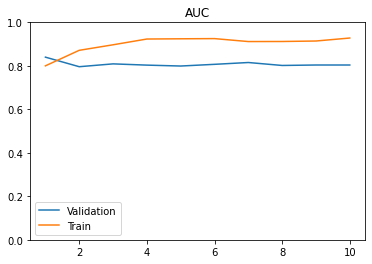

Wall time: 6min 9s


In [19]:
%%time

train_score = [0.8]
validation_score = [0.84]
all_metrics = {}

for i in range(2,max_poly_order+1):
    name = 'poly_batchnorm_{}'.format(i)
    checkdir = join(checkpoints_path, name)
    tensordir = join(tensor_path, name)
    tensor_call = TensorBoard(log_dir=tensordir)
    
    print('Order ', i)
    poly = PolynomialFeatures(degree=i)
    pol_x_train = poly.fit_transform(x_train_norm)
    pol_x_valid = poly.fit_transform(x_valid_norm)
    
    batchnorm_checkpoint_callback = ModelCheckpoint(filepath=checkdir,
                                                  save_weights_only=True,
                                                  monitor='val_auc',
                                                  mode='max',
                                                  save_best_only=True)
    
    poly_model = Sequential()
    poly_model.add(BatchNormalization())
    poly_model.add(Dense(units=1, activation='sigmoid', input_shape=(pol_x_train.shape[1],),  
                        kernel_regularizer=l2(0.05)))
    poly_model.compile(optimizer=Adam(learning_rate=0.02), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])

    history = poly_model.fit(pol_x_train, y_train, epochs=200, validation_data=(pol_x_valid, y_valid), callbacks=[batchnorm_checkpoint_callback, tensor_call], 
                             verbose=1, use_multiprocessing=True)
    
    # Cargo el mejor modelo entrenado
    poly_model.load_weights(checkdir)
    metrics = verify_model(poly_model, pol_x_train, y_train, pol_x_valid, y_valid)
    # Guardo las metricas de cada orden para comparar
    all_metrics[i] = metrics
    train_score.append(metrics['AUC ROC'][0])
    validation_score.append(metrics['AUC ROC'][1])
    clear_output(wait=True)
    
plt.plot(list(range(1, max_poly_order+1)),validation_score, label='Validation')
plt.plot(list(range(1, max_poly_order+1)),train_score, label='Train')
plt.title('AUC')
plt.ylim([0.0, 1.0])
plt.legend(loc='best')
plt.show()

In [20]:
validation_score

[0.84,
 0.7960354720918101,
 0.809076682316119,
 0.803338549817423,
 0.7991653625456443,
 0.8069900886802295,
 0.8153364632237872,
 0.801773604590506,
 0.8038601982263954,
 0.8038601982263953]

De estas pruebas se puede concluir que el mejor orden es el 6 con lo cual se continua la busca de hyperparámetros en dicho valor

In [21]:
poly = PolynomialFeatures(degree=6)
x_train_poly_6 = poly.fit_transform(x_train_norm)
x_valid_poly_6 = poly.fit_transform(x_valid_norm)

#### Busqueda del LR optimo

In [22]:
%%time
adam_lr = [1e-3, 2e-3, 5e-3, 8e-3, 0.01, 0.15, 0.02, 0.25]

arr_of_metrics = []
auc_res = {'L_r':['AUC', 'Epochs']}
for i in adam_lr:
    name = 'adam_poly_{}'.format(i)
    checkdir = join(checkpoints_path, name)
    tensordir = join(tensor_path, name)
    tensor_call = TensorBoard(log_dir=tensordir)
    
    adam_poly_checkpoint_callback = ModelCheckpoint(filepath=checkdir,
                                                  save_weights_only=True,
                                                  monitor='val_auc',
                                                  mode='max',
                                                  save_best_only=True)
    poly_6_mod = Sequential()
    poly_6_mod.add(BatchNormalization())
    poly_6_mod.add(Dense(units=1, activation='sigmoid', input_shape=(x_train_poly_6.shape[1],), kernel_regularizer=l2(0.05)))
    poly_6_mod.compile(optimizer=Adam(learning_rate=i), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])

    history = poly_6_mod.fit(x_train_poly_6, y_train, epochs=200, validation_data=(x_valid_poly_6, y_valid), callbacks=[adam_poly_checkpoint_callback, tensor_call], 
                          verbose=1, use_multiprocessing=True)
    # Cargo el mejor modelo entrenado
    poly_6_mod.load_weights(checkdir)
    metrics = verify_model(poly_6_mod, x_train_poly_6, y_train, x_valid_poly_6, y_valid)
    arr_of_metrics.append(metrics)
    auc_res[i] = [metrics['AUC ROC'][1], history.epoch[-1]]
    clear_output(wait=True)
pd.DataFrame(data=auc_res)

Wall time: 4min 37s


,L_r,0.001,0.002,0.005,0.008,0.01,0.15,0.02,0.25
0,AUC,0.764737,0.777256,0.782473,0.785081,0.786124,0.816901,0.80386,0.792384
1,Epochs,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.00000,199.000000


In [23]:
%%time

name = 'adam_poly'
checkdir = join(checkpoints_path, name)
tensordir = join(tensor_path, name)
tensor_call = TensorBoard(log_dir=tensordir)

    
adam_poly_checkpoint_callback = ModelCheckpoint(filepath=checkdir,
                                                  save_weights_only=True,
                                                  monitor='val_auc',
                                                  mode='max',
                                                  save_best_only=True)
poly_6_mod = Sequential()
poly_6_mod.add(BatchNormalization())
poly_6_mod.add(Dense(units=1, activation='sigmoid', input_shape=(x_train_poly_6.shape[1],), kernel_regularizer=l2(0.05)))
poly_6_mod.compile(optimizer=Adam(learning_rate=0.02), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])

history = poly_6_mod.fit(x_train_poly_6, y_train, epochs=200, validation_data=(x_valid_poly_6, y_valid), callbacks=[adam_poly_checkpoint_callback, tensor_call], 
                      verbose=1, use_multiprocessing=True)
# Cargo el mejor modelo entrenado
poly_6_mod.load_weights(checkdir)
metrics = verify_model(poly_6_mod, x_train_poly_6, y_train, x_valid_poly_6, y_valid)

Epoch 1/200
18/18 [==============================] - 2s 121ms/step - loss: 2.7957 - auc: 0.6310 - val_loss: 7.6489 - val_auc: 0.7081
Epoch 2/200
18/18 [==============================] - 0s 10ms/step - loss: 2.2023 - auc: 0.7593 - val_loss: 4.9187 - val_auc: 0.5824
Epoch 3/200
18/18 [==============================] - 0s 20ms/step - loss: 1.8282 - auc: 0.7732 - val_loss: 2.2552 - val_auc: 0.7640
Epoch 4/200
18/18 [==============================] - 0s 9ms/step - loss: 1.5996 - auc: 0.7923 - val_loss: 1.7828 - val_auc: 0.7517
Epoch 5/200
18/18 [==============================] - 0s 8ms/step - loss: 1.3365 - auc: 0.8056 - val_loss: 1.4781 - val_auc: 0.7230
Epoch 6/200
18/18 [==============================] - 0s 8ms/step - loss: 1.0418 - auc: 0.8099 - val_loss: 1.5819 - val_auc: 0.7525
Epoch 7/200
18/18 [==============================] - 0s 8ms/step - loss: 1.1767 - auc: 0.8285 - val_loss: 1.0046 - val_auc: 0.7632
Epoch 8/200
18/18 [==============================] - 0s 6ms/step - loss: 1.1398

In [24]:
metrics

,Set,AUC ROC,Especificidad,Sensibilidad,Valor Predictivo Positivo,Valor Predictivo Negativo
0,Train,0.933603,0.928775,0.699507,0.850299,0.842377
1,Validacion,0.812207,0.859155,0.518519,0.583333,0.824324


#### Optimize L2

In [25]:
%%time
l2_values = [0.25, 0.3, 0.35, 0.4]

arr_of_metrics = []
auc_res = {'L2':['AUC', 'Epochs']}
for i in l2_values:
    
    name = 'l2_poly_{}'.format(i)
    checkdir = join(checkpoints_path, name)
    tensordir = join(tensor_path, name)
    tensor_call = TensorBoard(log_dir=tensordir)

    l2_checkpoint_callback = ModelCheckpoint(filepath=checkdir,
                                                  save_weights_only=True,
                                                  monitor='val_auc',
                                                  mode='max',
                                                  save_best_only=True)
    poly_6_l2 = Sequential()
    poly_6_l2.add(BatchNormalization())
    poly_6_l2.add(Dense(units=1, activation='sigmoid', input_shape=(x_train_poly_6.shape[1],), kernel_regularizer=l2(i)))
    poly_6_l2.compile(optimizer=Adam(learning_rate=0.02), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])

    history = poly_6_l2.fit(x_train_poly_6, y_train, epochs=200, validation_data=(x_valid_poly_6, y_valid), callbacks=[l2_checkpoint_callback, tensor_call], 
                          verbose=0, use_multiprocessing=True)
    # Cargo el mejor modelo entrenado
    poly_6_l2.load_weights(checkdir)
    metrics = verify_model(poly_6_l2, x_train_poly_6, y_train, x_valid_poly_6, y_valid)
    arr_of_metrics.append(metrics)
    auc_res[i] = [metrics['AUC ROC'][1], history.epoch[-1]]
    clear_output(wait=True)
pd.DataFrame(data=auc_res)

Wall time: 1min 49s


,L2,0.25,0.3,0.35,0.4
0,AUC,0.814815,0.818466,0.814815,0.818466
1,Epochs,199.000000,199.000000,199.000000,199.000000


In [26]:
%%time

name = 'poly_l2_final'
checkdir = join(checkpoints_path, name)
tensordir = join(tensor_path, name)
tensor_call = TensorBoard(log_dir=tensordir)

l2_checkpoint_callback = ModelCheckpoint(filepath=checkdir,
                                                  save_weights_only=True,
                                                  monitor='val_auc',
                                                  mode='max',
                                                  save_best_only=True)
poly_6_l2 = Sequential()
poly_6_l2.add(BatchNormalization())
poly_6_l2.add(Dense(units=1, activation='sigmoid', input_shape=(x_train_poly_6.shape[1],), kernel_regularizer=l2(0.25)))
poly_6_l2.compile(optimizer=Adam(learning_rate=0.02), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])

history = poly_6_l2.fit(x_train_poly_6, y_train, epochs=200, validation_data=(x_valid_poly_6, y_valid), callbacks=[l2_checkpoint_callback, tensor_call], 
                      verbose=0, use_multiprocessing=True)
# Cargo el mejor modelo entrenado
poly_6_l2.load_weights(checkdir)
verify_model(poly_6_l2, x_train_poly_6, y_train, x_valid_poly_6, y_valid)

Wall time: 27.2 s


,Set,AUC ROC,Especificidad,Sensibilidad,Valor Predictivo Positivo,Valor Predictivo Negativo
0,Train,0.908004,0.903134,0.669951,0.800000,0.825521
1,Validacion,0.805947,0.929577,0.481481,0.722222,0.825000


In [27]:
poly = PolynomialFeatures(degree=6, interaction_only=True) #, include_bias=False)
x_train_poly_6_tuned = poly.fit_transform(x_train_norm)
x_valid_poly_6_tuned = poly.fit_transform(x_valid_norm)

In [28]:
%%time

name = 'poly_no_inter'
checkdir = join(checkpoints_path, name)
tensordir = join(tensor_path, name)
tensor_call = TensorBoard(log_dir=tensordir)

tunned_checkpoint_callback = ModelCheckpoint(filepath=checkdir,
                                                  save_weights_only=True,
                                                  monitor='val_auc',
                                                  mode='max',
                                                  save_best_only=True)
poly_6_nt = Sequential()
poly_6_nt.add(BatchNormalization())
poly_6_nt.add(Dense(units=1, activation='sigmoid', input_shape=(x_train_poly_6_tuned.shape[1],), kernel_regularizer=l2(0.25)))
poly_6_nt.compile(optimizer=Adam(learning_rate=0.02), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])

history = poly_6_nt.fit(x_train_poly_6_tuned, y_train, epochs=200, validation_data=(x_valid_poly_6_tuned, y_valid), callbacks=[tunned_checkpoint_callback, tensor_call], 
                      verbose=0, use_multiprocessing=True)
# Cargo el mejor modelo entrenado
poly_6_nt.load_weights(checkdir)
verify_model(poly_6_nt, x_train_poly_6_tuned, y_train, x_valid_poly_6_tuned, y_valid)

Wall time: 25 s


,Set,AUC ROC,Especificidad,Sensibilidad,Valor Predictivo Positivo,Valor Predictivo Negativo
0,Train,0.871711,0.911681,0.551724,0.783217,0.778589
1,Validacion,0.773083,0.901408,0.444444,0.631579,0.810127


In [29]:
history = poly_6_nt.fit(x_train_poly_6_tuned, y_train, epochs=200, validation_data=(x_valid_poly_6_tuned, y_valid), callbacks=[tunned_checkpoint_callback, tensor_call], 
                      verbose=1, use_multiprocessing=True, batch_size=10)
# Cargo el mejor modelo entrenado
poly_6_nt.load_weights(join(checkpoints_path, 'poly_no_inter'))
verify_model(poly_6_nt, x_train_poly_6_tuned, y_train, x_valid_poly_6_tuned, y_valid)

Epoch 1/200
56/56 [==============================] - 1s 18ms/step - loss: 0.7052 - auc: 0.7621 - val_loss: 0.7022 - val_auc: 0.7147
Epoch 2/200
56/56 [==============================] - 0s 3ms/step - loss: 0.6372 - auc: 0.7943 - val_loss: 0.7156 - val_auc: 0.7102
Epoch 3/200
56/56 [==============================] - 0s 3ms/step - loss: 0.6259 - auc: 0.7886 - val_loss: 0.5981 - val_auc: 0.7587
Epoch 4/200
56/56 [==============================] - 0s 3ms/step - loss: 0.5909 - auc: 0.8087 - val_loss: 0.6205 - val_auc: 0.7692
Epoch 5/200
56/56 [==============================] - 0s 4ms/step - loss: 0.5965 - auc: 0.8074 - val_loss: 0.6296 - val_auc: 0.7173
Epoch 6/200
56/56 [==============================] - 0s 4ms/step - loss: 0.5641 - auc: 0.8228 - val_loss: 0.5842 - val_auc: 0.7598
Epoch 7/200
56/56 [==============================] - 0s 6ms/step - loss: 0.5945 - auc: 0.7893 - val_loss: 0.5550 - val_auc: 0.7814
Epoch 8/200
56/56 [==============================] - 0s 2ms/step - loss: 0.5532 - 

,Set,AUC ROC,Especificidad,Sensibilidad,Valor Predictivo Positivo,Valor Predictivo Negativo
0,Train,0.857550,0.914530,0.507389,0.774436,0.76247
1,Validacion,0.781429,0.943662,0.481481,0.764706,0.82716


In [30]:
poly = PolynomialFeatures(degree=6)
test = poly.fit_transform(x_test_norm)
verify_model(poly_6_l2, x_train_poly_6, y_train, test, y_test, valid_label='Test')

,Set,AUC ROC,Especificidad,Sensibilidad,Valor Predictivo Positivo,Valor Predictivo Negativo
0,Train,0.908004,0.903134,0.669951,0.800000,0.825521
1,Test,0.839406,0.833333,0.605263,0.638889,0.812500


In [31]:
f2_threshold(poly_6_l2, x_train_poly_6, y_train, x_valid_poly_6, y_valid)

TypeError: fbeta_score() missing 1 required keyword-only argument: 'beta'